# Data Exploration

## General

This notebook explores the data generated for training with the simulator.
I used two datasets and a two step approach for training.

This notebook is split into two sections, which correspond to the data used for each python training script.

Please note that the weights were saved and then loaded into the second script for training.

### model_before

1st model trained, data augmentation was kept to a minimum (only flipping images).
1st track laps driven in both directions.
Special laps driven with just the curvy section recorded.

In [1]:
# make necessary imports
import pandas as pd
import csv
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read in data
data = pd.read_csv('./cont_data_w_add/driving_log.csv', header=None)

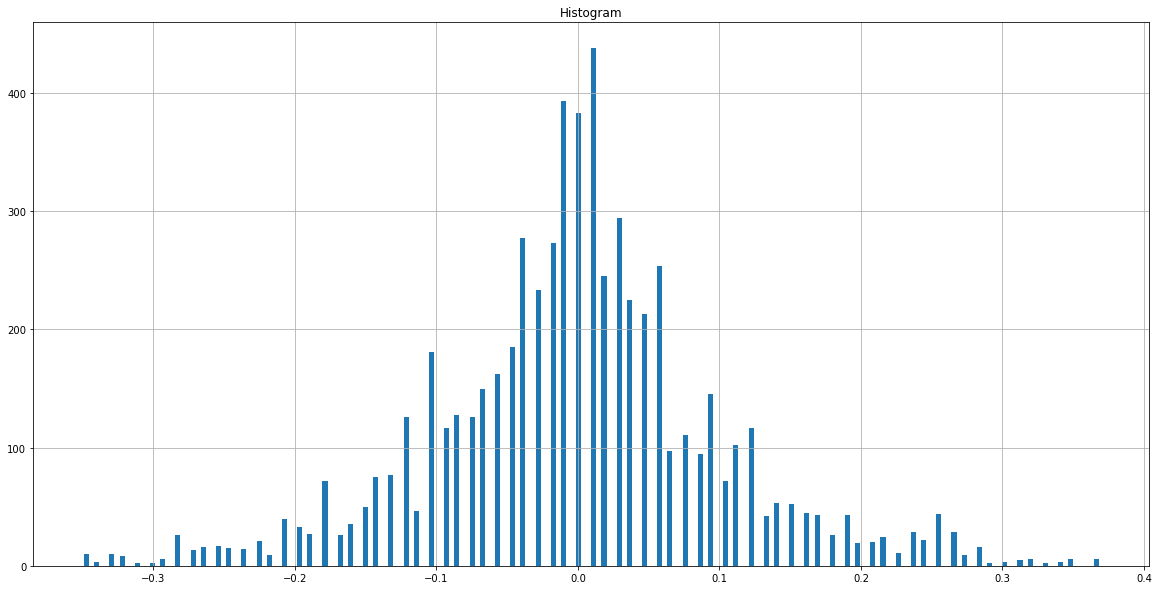

In [3]:
ax = data[3].hist(bins=200, figsize=(20,10))
ax.set_title('Histogram')
plt.savefig('./histogram.png')

In [4]:
data[3].describe()

count    6355.000000
mean       -0.001502
std         0.103038
min        -0.349057
25%        -0.056604
50%         0.000000
75%         0.047170
max         0.367924
Name: 3, dtype: float64

In [5]:
print('Number of rows: {}'.format(data.shape[0]))
print('Total number of images: {}'.format(data.shape[0]*3))

Number of rows: 6355
Total number of images: 19065


As there are 3 images per row (center, left, right) we have a total of 11355 images to work with. We can see that there are a lot of steering angles close to 0, with a slight bias of steering left (because of the track). To account for that, images with certain steering angles are ommitted. Also, images are randomly flipped.

Keep in mind that this number can change if the generator returns additional augmented data or omits certain data.

In [6]:
'''
The following lines of code are straight from the model_before.py file.
'''

# imports for reading the data
import os
import csv
from sklearn.model_selection import train_test_split

# path to data Folder
path = './my_new_data/'

# read in the csv
samples = []
with open(path+'driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)

# split data into train and validation set
train_samples, validation_samples = train_test_split(samples, test_size=0.2)

# make all necessary imports for working with the data
import cv2
import numpy as np
import sklearn
from scipy.misc import imresize
import random

# define a generator
def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        sklearn.utils.shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                                
                # read in all 3 images
                name = path+'IMG/'+batch_sample[0].split('\\')[-1]
                name_left = path+'IMG/'+batch_sample[1].split('\\')[-1]
                name_right = path+'IMG/'+batch_sample[2].split('\\')[-1]

                # read in steering angle
                center_angle = float(batch_sample[3])

                # make random number to omit certian samples with a probaility
                random_num = random.random()

                # correction parameter for images left and right
                correction = 0.25

                # randomly omit 70% of driving "straight" (angle between -0.15 and 0.15)                
                if center_angle < 0.15 and center_angle > -0.15 and random_num > 0.3:
                    pass

                else:
                    # create adjusted steering measurements for the side camera images
                    steering_left = center_angle + correction
                    steering_right = center_angle - correction
                
                    center_image = cv2.imread(name)
                    left_image = cv2.imread(name_left)
                    right_image = cv2.imread(name_right)

                    # trim image to only see section with road and resize for nvidea model (66 x 200)
                    center_image = center_image[68:136, 0:320]
                    center_image = cv2.resize(center_image, (200, 66))

                    left_image = left_image[68:136, 0:320]
                    left_image = cv2.resize(left_image, (200, 66))

                    right_image = right_image[68:136, 0:320]
                    right_image = cv2.resize(right_image, (200, 66))

                    # randomly flip images with a probability of 50%
                    if random_num > 0.5:
                        images.extend([center_image, left_image, right_image])
                        angles.extend([center_angle, steering_left, steering_right])

                    else:
                        # flip images
                        image_flipped_c = np.fliplr(center_image)
                        measurement_flipped_c = -center_angle

                        image_flipped_l = np.fliplr(left_image)
                        measurement_flipped_l = -steering_left

                        image_flipped_r = np.fliplr(right_image)
                        measurement_flipped_r = -steering_right

                        images.extend([image_flipped_c, image_flipped_l, image_flipped_r])
                        angles.extend([measurement_flipped_c, measurement_flipped_l, measurement_flipped_r])
                        
            X_train = np.array(images)          
            y_train = np.array(angles)
            
            yield sklearn.utils.shuffle(X_train, y_train)

In [7]:
# use generator to get samples

for i in range(3):
    x,y = next(generator(train_samples, batch_size=32))
    x = np.array(x)
    y = np.array(y)
    print('Number of images: {}'.format(y.shape[0]))

Number of images: 36
Number of images: 39
Number of images: 51


Each time the generator is run there is a different amount of images returned. This is due to the random ommiting of certain steering angles and the fact that we are reading in 32 lines with 3 images each.

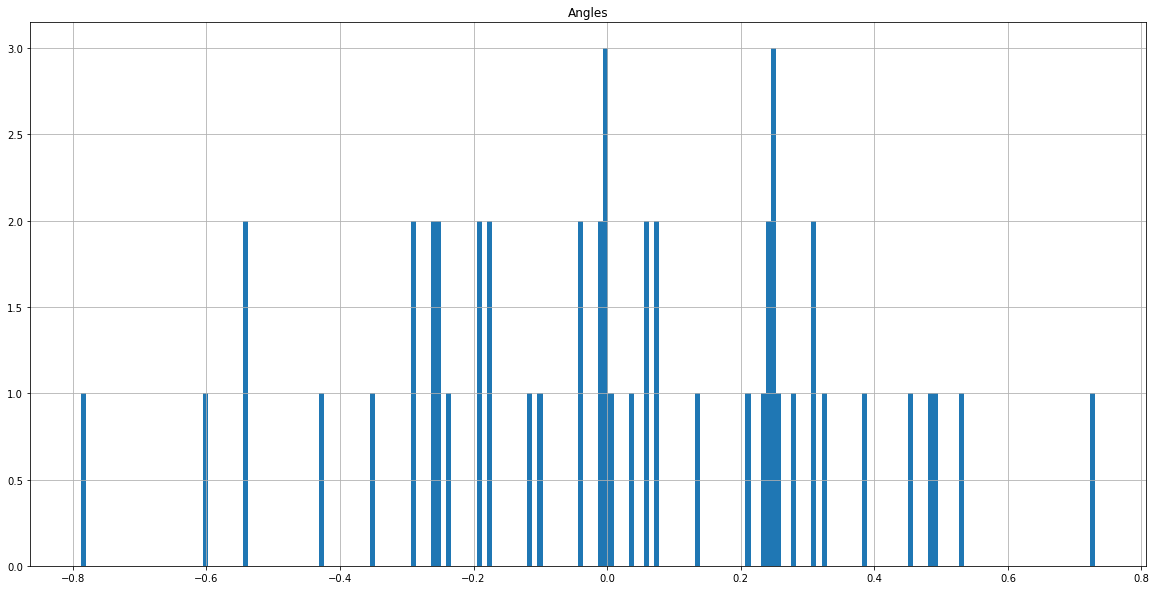

In [8]:
GeneratedData = pd.DataFrame()
GeneratedData['Angles'] = y
ax = GeneratedData.hist(bins=200, figsize=(20,10))
plt.savefig('./histogram_gen_model_before.png')

As visible the data is more evenly distributed than before.

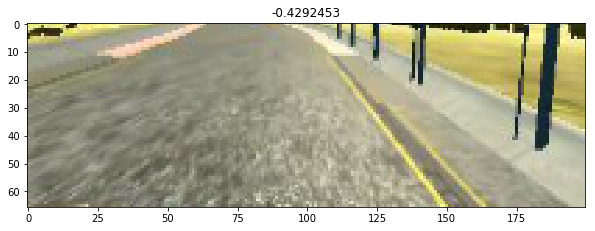

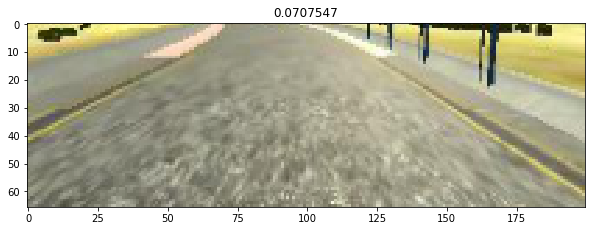

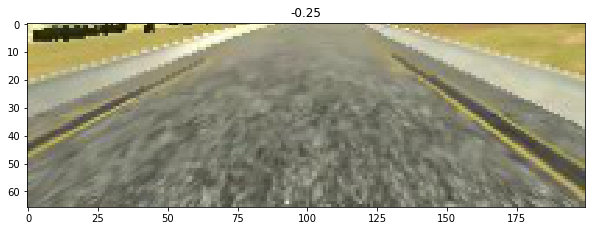

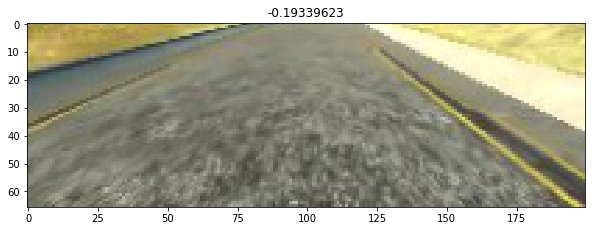

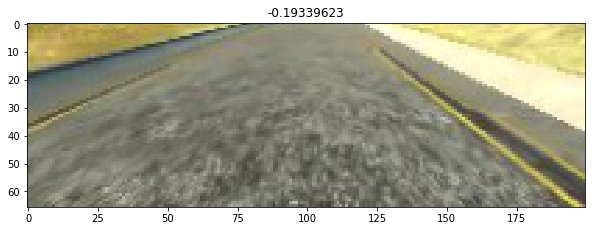

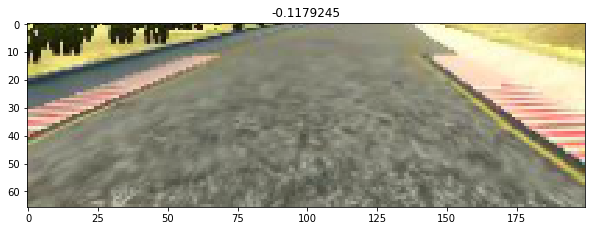

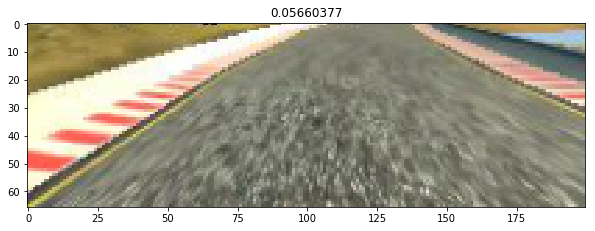

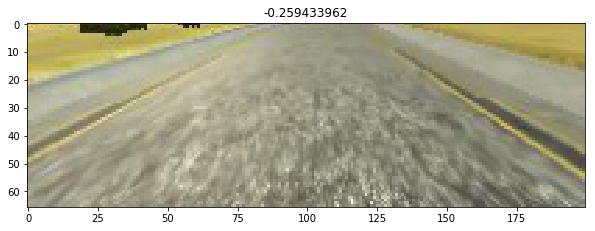

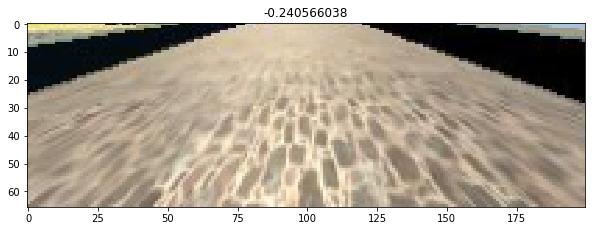

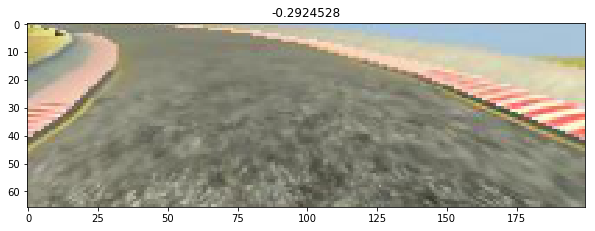

In [9]:
# print 10 random images form our last batch of generated images
for i in range(10):
    index = random.randint(0,len(y)-1)
    plt.figure(figsize=(10,10))
    plt.imshow(cv2.cvtColor(x[index], cv2.COLOR_BGR2RGB))
    plt.title(y[index])
    
    plt.savefig('./10_samples_model_before{}.png'.format(i))

The images are relatively unspectecular, since no augmentation techniques were used here.

### model

2nd model trained, data augmentation was used (brighness, flipping, shadows, shifts).
1st track driven 2 laps.
Recovery lap driven with recordings from the side driving back 
towards the center of the road (from the left and right side).

In [10]:
# read in data
data = pd.read_csv('./my_new_data/driving_log.csv', header=None)

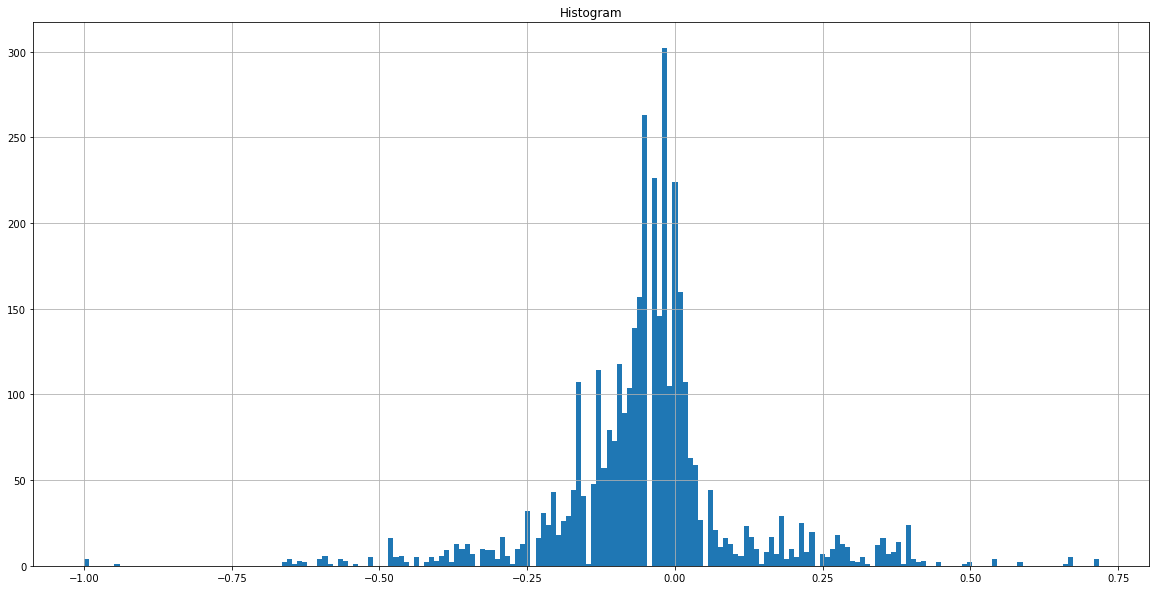

In [11]:
ax = data[3].hist(bins=200, figsize=(20,10))
ax.set_title('Histogram')
plt.savefig('./histogram_2.png')

In [12]:
data[3].describe()

count    3785.000000
mean       -0.045643
std         0.156019
min        -1.000000
25%        -0.103774
50%        -0.037736
75%         0.000000
max         0.716981
Name: 3, dtype: float64

In [13]:
print('Number of rows: {}'.format(data.shape[0]))
print('Total number of images: {}'.format(data.shape[0]*3))

Number of rows: 3785
Total number of images: 11355


In [14]:
'''
The following lines of code are straight from the model_before.py file.
'''

# imports for reading the data
import os
import csv
from sklearn.model_selection import train_test_split

# path to data Folder
path = './my_new_data/'

# read in the csv
samples = []
with open(path+'driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)

# split data into train and validation set
train_samples, validation_samples = train_test_split(samples, test_size=0.2)

# make all necessary imports for working with the data
import cv2
import numpy as np
import sklearn
from scipy.misc import imresize
import random

# define function to randomly adjust brightness
def random_brighness(img):
    image1 = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
    image1 = np.array(image1, dtype = np.float64)
    random_bright = .5+np.random.uniform()
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1[:,:,2][image1[:,:,2]>255]  = 255
    image1 = np.array(image1, dtype = np.uint8)
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1

# define function to randomly shift the image and
# adjust the steering angle for shifted pixels
def trans_image(image,steer,trans_range):
    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    steer_ang = steer + tr_x/trans_range*2*.2
    tr_y = 40*np.random.uniform()-40/2
    #tr_y = 0
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])
    image_tr = cv2.warpAffine(image,Trans_M,(200,66))
    return image_tr,steer_ang

# define funstion for random shaddows
def add_random_shadow(image):
    top_y = 200*np.random.uniform()
    top_x = 0
    bot_x = 66
    bot_y = 200*np.random.uniform()
    image_hls = cv2.cvtColor(image,cv2.COLOR_RGB2HLS)
    shadow_mask = 0*image_hls[:,:,1]
    X_m = np.mgrid[0:image.shape[0],0:image.shape[1]][0]
    Y_m = np.mgrid[0:image.shape[0],0:image.shape[1]][1]
    shadow_mask[((X_m-top_x)*(bot_y-top_y) -(bot_x - top_x)*(Y_m-top_y) >=0)]=1
    #random_bright = .25+.7*np.random.uniform()
    if np.random.randint(2)==1:
        random_bright = .5
        cond1 = shadow_mask==1
        cond0 = shadow_mask==0
        if np.random.randint(2)==1:
            image_hls[:,:,1][cond1] = image_hls[:,:,1][cond1]*random_bright
        else:
            image_hls[:,:,1][cond0] = image_hls[:,:,1][cond0]*random_bright    
    image = cv2.cvtColor(image_hls,cv2.COLOR_HLS2RGB)
    return image


# define a generator to augment and read data when needed
def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        sklearn.utils.shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                                
                # read in all 3 images
                name = path+'IMG/'+batch_sample[0].split('\\')[-1]
                name_left = path+'IMG/'+batch_sample[1].split('\\')[-1]
                name_right = path+'IMG/'+batch_sample[2].split('\\')[-1]

                # read in steering angle
                center_angle = float(batch_sample[3])

                # make random number to omit certian samples with a probaility
                random_num = random.random()

                # correction parameter for images left and right
                correction = 0.25
                
                # if going left randomly omit 30% of the data (otherwise car stays too far left)
                if center_angle <=0 and random_num > 0.7:
                    pass
                
                # if going close to straight (with steering between -0.15 and 0.15) then
                # only read in the left and right image data, not the centered one
                if center_angle < 0.15 and center_angle > -0.15 and random_num > 0.4:
                    
                    # create adjusted steering measurements for the side camera images
                    steering_left = center_angle + correction
                    steering_right = center_angle - correction

                    left_image = cv2.imread(name_left)
                    right_image = cv2.imread(name_right)

                    # trim image to only see section with road and resize for nvidea model (66 x 200)
                    left_image = left_image[68:136, 0:320]
                    left_image = cv2.resize(left_image, (200, 66))

                    right_image = right_image[68:136, 0:320]
                    right_image = cv2.resize(right_image, (200, 66))

                    images.extend([left_image, right_image])
                    angles.extend([steering_left, steering_right])

                    # flip images and add them (doubles the size of training data)
                    image_flipped_l = np.fliplr(left_image)
                    measurement_flipped_l = -steering_left

                    image_flipped_r = np.fliplr(right_image)
                    measurement_flipped_r = -steering_right

                    images.extend([image_flipped_l, image_flipped_r])
                    angles.extend([measurement_flipped_l, measurement_flipped_r])

                else:

                    # create adjusted steering measurements for the side camera images
                    steering_left = center_angle + correction
                    steering_right = center_angle - correction
                
                    center_image = cv2.imread(name)
                    left_image = cv2.imread(name_left)
                    right_image = cv2.imread(name_right)

                    # trim image to only see section with road and resize for nvidea model (66 x 200)
                    center_image = center_image[68:136, 0:320]
                    center_image = cv2.resize(center_image, (200, 66))

                    left_image = left_image[68:136, 0:320]
                    left_image = cv2.resize(left_image, (200, 66))

                    right_image = right_image[68:136, 0:320]
                    right_image = cv2.resize(right_image, (200, 66))

                    images.extend([center_image, left_image, right_image])
                    angles.extend([center_angle, steering_left, steering_right])

                    # flip images
                    image_flipped_c = np.fliplr(center_image)
                    measurement_flipped_c = -center_angle

                    image_flipped_l = np.fliplr(left_image)
                    measurement_flipped_l = -steering_left

                    image_flipped_r = np.fliplr(right_image)
                    measurement_flipped_r = -steering_right

                    images.extend([image_flipped_c, image_flipped_l, image_flipped_r])
                    angles.extend([measurement_flipped_c, measurement_flipped_l, measurement_flipped_r])

            #add augmented data with random brightness adjustions, shifts and shadow
            aug_images=[]
            aug_angles=[]
            for image, angle in zip(images, angles):
                for _ in range(1):
                    aug_images.append(random_brighness(image))
                    aug_angles.append(angle)

                    t_im, t_st = trans_image(image,angle,25)
                    aug_images.append(t_im)
                    aug_angles.append(t_st)

                    aug_images.append(add_random_shadow(image))
                    aug_angles.append(angle)

            images.extend(aug_images)
            angles.extend(aug_angles)
                        
            X_train = np.array(images)          
            y_train = np.array(angles)
            
            yield sklearn.utils.shuffle(X_train, y_train)

In [19]:
# use generator to get samples

for i in range(3):
    x,y = next(generator(train_samples, batch_size=32))
    x = np.array(x)
    y = np.array(y)
    print('Number of images: {}'.format(y.shape[0]))

Number of images: 624
Number of images: 648
Number of images: 664


WOW, wayy more images, why is that? Well, we augment a lot of data! We start by doubling the number of images because we flip every image available. We also add left and right images even if the car is close to going straight. Lastly, we triple the total number by adding augmented data.

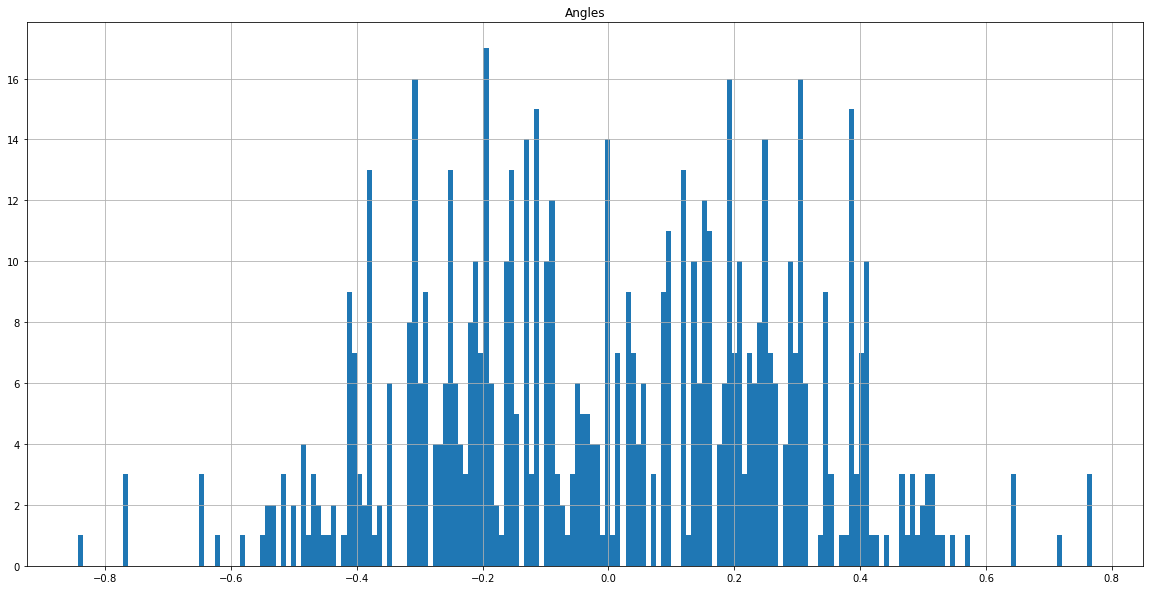

In [20]:
GeneratedData = pd.DataFrame()
GeneratedData['Angles'] = y
ax = GeneratedData.hist(bins=200, figsize=(20,10))
plt.savefig('./histogram_gen_model.png')

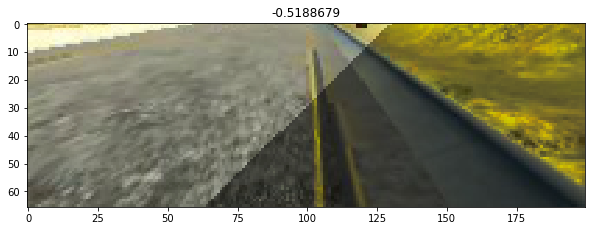

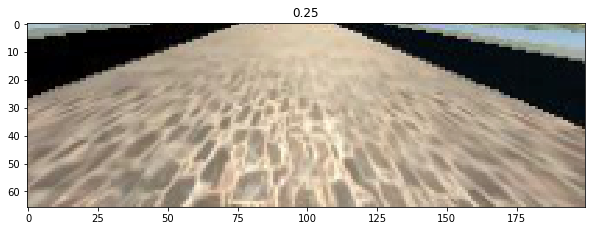

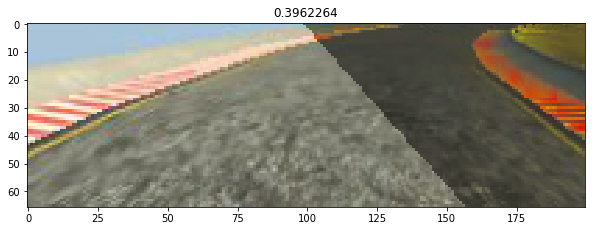

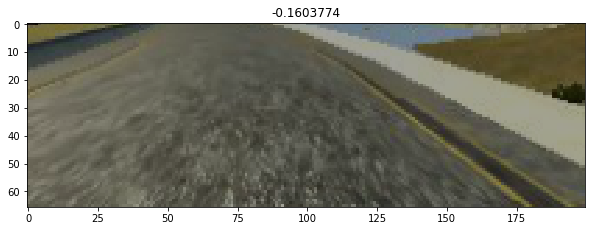

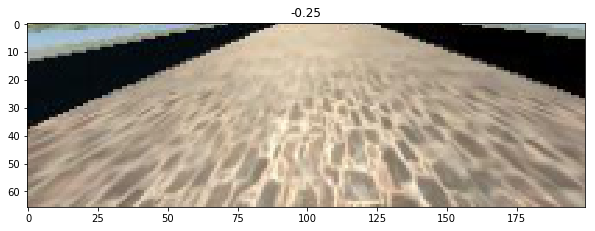

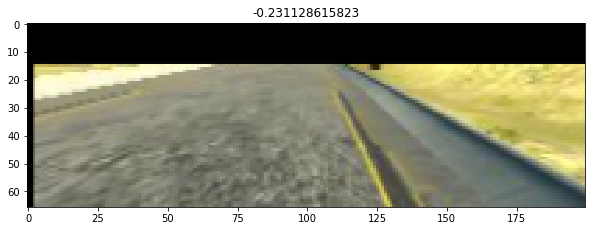

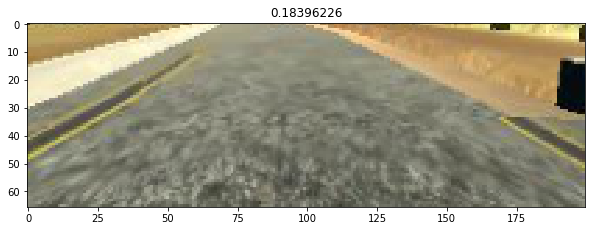

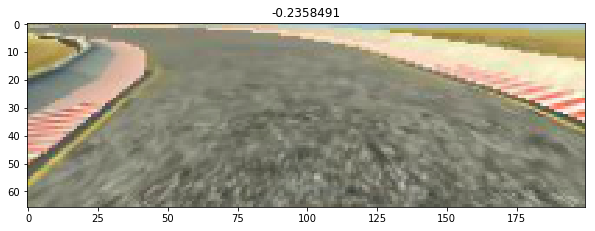

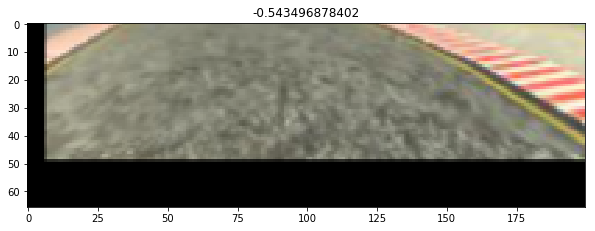

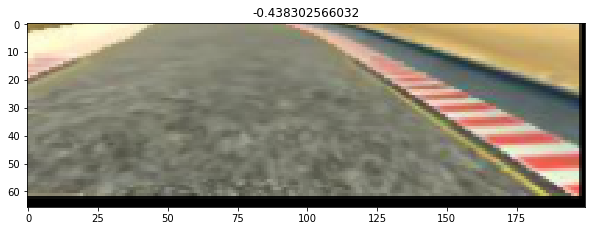

In [21]:
# print 10 random images form our last batch of generated images
for i in range(10):
    index = random.randint(0,len(y)-1)
    plt.figure(figsize=(10,10))
    plt.imshow(cv2.cvtColor(x[index], cv2.COLOR_BGR2RGB))
    plt.title(y[index])
    
    plt.savefig('./10_samples_model{}.png'.format(i))

In this case, the data is more fun to look at! We can see images that are shifted, different levels of brightness and shadows!